In [1]:
using Pkg
Pkg.activate("..")
using PlotlyJS
using StatsPlots
# default(format="png")
plotlyjs()
using DataFrames
using CSV
using Dates
using Clustering
using CategoricalArrays
using Statistics
using LinearAlgebra
using StatsBase
using ProgressMeter
using SparseArrays

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-3408798834803233363\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-14380160340233399062\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-3408798834803233363\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [2]:
df = CSV.read("../data/customer-clustering/US Superstore data.csv", DataFrame;
    dateformat="m/d/yyyy",
    normalizenames=true,
    threaded=true)
for name in names(df)
    if eltype(df[!, name]) <: AbstractFloat
        df[!, name] = convert(Vector{Float32}, df[!, name])
    elseif eltype(df[!, name]) <: Integer
        df[!, name] = convert(Vector{Int32}, df[!, name])
    end
end
first(df, 4)

,Row_ID,Order_ID,Order_Date,Ship_Date,Ship_Mode,Customer_ID,Customer_Name
,Int32,String,Date,Date,String,String,String
1,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute
2,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute
3,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff
4,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell


In [3]:
groupby(df, :Customer_ID)

,Row_ID,Order_ID,Order_Date,Ship_Date,Ship_Mode,Customer_ID,Customer_Name
,Int32,String,Date,Date,String,String,String
1,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute
2,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute
3,5492,CA-2017-164098,2017-01-26,2017-01-27,First Class,CG-12520,Claire Gute
4,6878,US-2015-123918,2015-10-15,2015-10-15,Same Day,CG-12520,Claire Gute
5,6879,US-2015-123918,2015-10-15,2015-10-15,Same Day,CG-12520,Claire Gute
,Row_ID,Order_ID,Order_Date,Ship_Date,Ship_Mode,Customer_ID,Customer_Name
,Int32,String,Date,Date,String,String,String
1,9559,CA-2016-129280,2016-05-03,2016-05-05,First Class,SM-20905,Susan MacKendrick
2,9560,CA-2016-129280,2016-05-03,2016-05-05,First Class,SM-20905,Susan MacKendrick


In [256]:
@show names(df)

names(df) = ["Row_ID", "Order_ID", "Order_Date", "Ship_Date", "Ship_Mode", "Customer_ID", "Customer_Name", "Segment", "Country", "City", "State", "Postal_Code", "Region", "Product_ID", "Category", "Sub_Category", "Product_Name", "Sales", "Quantity", "Discount", "Profit"]


21-element Vector{String}:
 "Row_ID"
 "Order_ID"
 "Order_Date"
 "Ship_Date"
 "Ship_Mode"
 "Customer_ID"
 "Customer_Name"
 "Segment"
 "Country"
 "City"
 "State"
 "Postal_Code"
 "Region"
 "Product_ID"
 "Category"
 "Sub_Category"
 "Product_Name"
 "Sales"
 "Quantity"
 "Discount"
 "Profit"

In [270]:
function preprocess(df)
    catcode(x) = levelcode.(compress(categorical(x)))
    df = transform(df,
        :Ship_Mode => catcode,
        :Category => catcode,
        :Segment => catcode,
    )
    mean(x) = (Float32 ∘ Statistics.mean)(x)
    combine(groupby(df, :Customer_ID),
        :Segment_catcode => mode,
        :Ship_Mode_catcode => mode,
        :Quantity => mean,
        :Discount => mean,
        :Profit => mean,
        :Sales => mean,
        :Category_catcode => mode,
    )
end
aux = preprocess(df)
first(aux, 3)

,Customer_ID,Segment_catcode_mode,Ship_Mode_catcode_mode,Quantity_mean,Discount_mean
,String,Int16,Int16,Float32,Float32
1,CG-12520,1,3,2.8,0.2
2,DV-13045,2,4,3.11111,0.172222
3,SO-20335,1,4,3.46667,0.136667


In [356]:
function pca(df)
    dataCols = filter(name -> eltype(df[!, name]) <: Number, 
        names(df))
    data = reduce(hcat, df[!, name] for name in dataCols)
    R = coalesce.(cor(data), 0)
    vals, vecs = eigen(R; permute=false)
    total = sum(vals)
    perm = sortperm(vals; rev=true)
    vals = vals[perm]
    vecs = vecs[perm]
    proportions = map(val -> val / total, vals)
    take = findfirst(≥(0.9), cumsum(proportions))
    (perm = perm,
        vals = vals,
        vecs = vecs,
        proportions = proportions,
        take = 1:take,
        names = dataCols[perm])
end
pcaResult = pca(aux)

(perm = [7, 6, 5, 4, 3, 2, 1], vals = Float32[1.6218531, 1.1543858, 1.0190065, 1.0085666, 0.9361125, 0.7635952, 0.4964797], vecs = Float32[-0.08094751, -0.578683, 0.7026946, 0.3585786, 0.17754927, 0.06344778, 0.025802724], proportions = Float32[0.23169333, 0.16491228, 0.14557238, 0.14408097, 0.13373038, 0.109085046, 0.07092568], take = 1:6, names = ["Category_catcode_mode", "Sales_mean", "Profit_mean", "Discount_mean", "Quantity_mean", "Ship_Mode_catcode_mode", "Segment_catcode_mode"])

In [383]:
function gower(df)
    id = df.Customer_ID
    names_ = names(df)
    cat_cols = filter(x -> eltype(df[!, x]) <: Integer, names_)
    num_cols = filter(x -> eltype(df[!, x]) <: AbstractFloat, names_)
    ranges = Dict(map(num_cols) do col
                col => maximum(df[!, col]) - minimum(df[!, col])
            end)
    n = length(id)
    dists = spzeros(n, n)
    for i = 1:n, j = i+1:n
        for col in cat_cols
            dists[i, j] += (df[i, col] == df[j, col])
        end
        for col in num_cols
            dists[i, j] += abs(df[i, col] - df[j, col]) / ranges[col]
        end
    end
    return Symmetric(dists, :U)
end
dists = gower(aux);
size(dists)

(793, 793)

In [450]:
# function gridsearch(algo, arg; maxn)
#     costs = map(2:maxn) do n
#         result = algo(arg, n)
#         (ncluster = n, totalcost = result.totalcost,)
#     end
#     sort(DataFrame(costs), :totalcost)
# end
# gridsearch(kmedoids, dists; maxn=5)

DataFrame(enumerate(names)) = 8×2 DataFrame
 Row │ 1      2
     │ Int64  String
─────┼───────────────────────────────
   1 │     1  Customer_ID
   2 │     2  Segment_catcode_mode
   3 │     3  Ship_Mode_catcode_mode
   4 │     4  Quantity_mean
   5 │     5  Discount_mean
   6 │     6  Profit_mean
   7 │     7  Sales_mean
   8 │     8  Category_catcode_mode
r.totalcost = 358.1381411157337


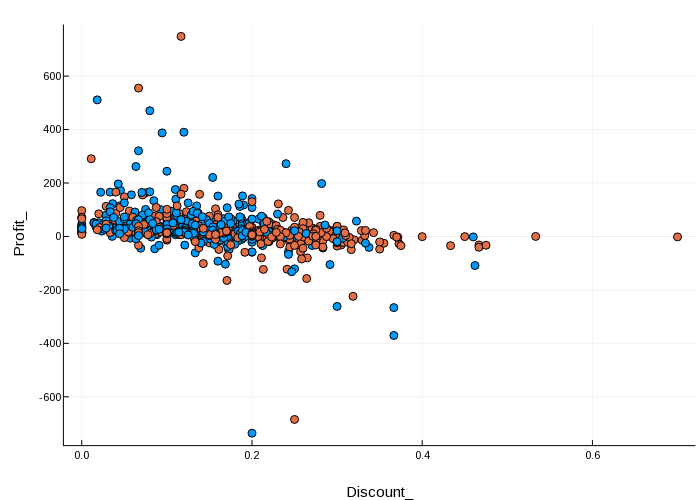

In [455]:
let names = names(aux)
    @show DataFrame(enumerate(names))
    r = kmedoids(dists, 2)
    @show r.totalcost
    x = names[5]
    y = names[6]
#     z = names[7]
    StatsPlots.scatter(
        aux[!, x], 
        aux[!, y],
#         aux[!, z],
        label = false,
        color = r.assignments,
        xlabel = replace(x, "mean" => ""),
        ylabel = replace(y, "mean" => "")
#         zlabel = z
    )
end